In [1]:
%pylab inline

import os

import itertools as it
from scipy.optimize import leastsq
from string import join
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits

from densitycontour import densitycontour

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
write_tables_for_fig4 = False

def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"])
                               for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

def deg(t, m, p0):
    t0, Z0 = p0
    return m*array(t) + (Z0-m*t0)

def unbiased_disc(model_spec, model_jpas, residual_spec, residual_jpas):
    return (model_jpas-model_spec) - (median(residual_jpas)-median(residual_spec))

od = os.path.expandvars("$HOME/Documents/Publications/PhD-thesis/figures/")

greys_map = cm._generate_cmap(greys_map_name, 256)
greys_map_r = cm._generate_cmap(greys_map_name+"_r", 256)
diver_map = cm._generate_cmap(diver_map_name, 256)
seque_map = cm._generate_cmap(seque_map_name, 256)

In [3]:
#READ TABLES

emission_detections = loadtxt("../inputs/real_deal/jpas_residual_emission.txt", dtype=str)
Lfrac = put_FITS_names(genfromtxt("data/sample-obs/lumfrac.txt", dtype=None, names=True))
snr_spec = genfromtxt("data/sample-obs/snr_spec.txt", dtype=None, names=True)
snr_jpas = genfromtxt("data/sample-obs/snr_jpas.txt", dtype=None, names=True)
Cind = put_FITS_names(genfromtxt("data/sample-obs/conIndex_test.txt", dtype=None, names=True))
u_lib, g_lib, r_lib, i_lib, z_lib = loadtxt("../inputs/tta_cb13/ssag/set_catalog.txt", usecols=range(1,1+5), unpack=True)
catalog = genfromtxt("data/sample-obs/catalog.txt", dtype=None, names=True)
gal2005 = genfromtxt("data/sample-obs/gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])

g05_mod_name = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_mod.log"), dtype=np.str, usecols=(0,))
g05_mindx = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_mod.log"), usecols=(1,2,3,4,5))
g05_mindx = g05_mindx[argsort(g05_mod_name)]

g05_obs_name = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_obs.log"), dtype=np.str, usecols=(0,))
g05_oindx = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_obs.log"), usecols=(1,2,3,4,5))
g05_oindx = g05_oindx[argsort(g05_obs_name)]

outs = os.path.expandvars("$phd/inputs/real_deal/outs")
change_name = lambda name, strip: "spSpec"+name.lstrip(strip).replace(".log", ".fit")

spec_ne = genfromtxt("{}/spec/dynbas_output.log".format(outs), dtype=None, names=True)
spec_ne["input_file"] = array([change_name(name, "dynbasfit_processed_SPEC_") for name in spec_ne["input_file"]])
spec_ne["M_mod"] = log10(spec_ne["M_mod"])

jpas_ne = genfromtxt("{}/nem_jpas/dynbas_output.log".format(outs), dtype=None, names=True)
jpas_ne["input_file"] = array([change_name(name, "dynbasfit_processed_nem_JPAS_") for name in jpas_ne["input_file"]])
jpas_ne["M_mod"] = log10(jpas_ne["M_mod"])
                                                           
parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])

In [4]:
#COMMON MASKS
in_spec_ne = array([galaxy in spec_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_jpas_ne = array([galaxy in jpas_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_gal2005 = array([galaxy in gal2005["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
g05_in_sam = array([galaxy in spec_ne["input_file"] for galaxy in gal2005["input_file"]], dtype=bool)
sam_in_g05 = array([galaxy in gal2005["input_file"] for galaxy in spec_ne["input_file"]], dtype=bool)
nem_detect = ~array([galaxy in emission_detections for galaxy in spec_ne["input_file"]], dtype=bool)

#COMMON QUANTITIES
col = (catalog["u_mag"] - catalog["r_mag"])[in_spec_ne]
cat = catalog[in_spec_ne]
lfr = Lfrac[in_spec_ne]
con, rat = array([[
            row["petroR90_r"]/row["petroR50_r"],
            1.5/row["petroR90_r"]
        ] if row["petroR50_r"]!=0 and row["petroR90_r"]!=0 else [inf, inf] for row in Cind[in_spec_ne]]).T
g05 = gal2005[g05_in_sam]
print "tables match?", all(spec_ne["input_file"]==cat["input_file"])&all(cat["input_file"]==lfr["input_file"])&\
                       all(cat["input_file"]==Cind["input_file"][in_spec_ne])&\
                       all(cat["input_file"][sam_in_g05]==g05["input_file"])

#SAMPLE DEFINITION MASKS
# mask for g05 subsamples
SF_hSNR_g05_mask = (sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]>15.0)
SF_hSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]>15.0)
Pa_hSNR_g05_mask = (sam_in_g05)&(col>=2.22)&(snr_spec["snr_wall"]>15.0)
# mask for cat subsamples
SF_lSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]<=15.0)
Pa_lSNR_m16_mask = (~sam_in_g05)&(col>=2.22)&(snr_spec["snr_wall"]<=15.0)

# mask for removing trash
clean = nem_detect&(snr_spec["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)
clean = clean&(col>=1)&(col<=3.3)&(snr_jpas["npix_CaII"]>0)&(snr_jpas["npix_CaHK"]>0)

# masks for MPA-Garching subsample filtering
mask_m16 = clean&(sam_in_g05)
mask_g05 = clean[sam_in_g05]

# masks for galaxies classification
sfgs = col<2.22
pags = col>=2.22
algs = sfgs|pags

#WRITE DISCREPANCY TABLES(?)
if write_tables_for_fig4:
    savetxt("data/sample-sim/ur_color.txt", col[clean])
    for i, field in enumerate(spec_ne.dtype.names):
        if i in [2,3,4,5,6,7]:
            savetxt("data/sample-sim/JPAS_{0}.txt".format(field), jpas_ne[clean][field])
            savetxt("data/sample-sim/SPEC_{0}.txt".format(field), spec_ne[clean][field])
    write_tables_for_fig4 = True
    print "tables written"

tables match? True


In [5]:
NR = 20

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in fields]

jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

jpas_res = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
tta_con = dict(
    M=unbiased_disc(spec_tta["M_mod"], jpas_tta["M_mod"], spec_res["M"], jpas_res["M"]),
    log_t_M=unbiased_disc(spec_tta["log_t_M_mod"], jpas_tta["log_t_M_mod"], spec_res["log_t_M"], jpas_res["log_t_M"]),
    log_t_L=unbiased_disc(spec_tta["log_t_L_mod"], jpas_tta["log_t_L_mod"], spec_res["log_t_L"], jpas_res["log_t_L"]),
    log_Z_M=unbiased_disc(spec_tta["log_Z_M_mod"], jpas_tta["log_Z_M_mod"], spec_res["log_Z_M"], jpas_res["log_Z_M"]),
    log_Z_L=unbiased_disc(spec_tta["log_Z_L_mod"], jpas_tta["log_Z_L_mod"], spec_res["log_Z_L"], jpas_res["log_Z_L"]),
    Av=unbiased_disc(spec_tta["Av_mod"], jpas_tta["Av_mod"], spec_res["Av"], jpas_res["Av"])
)
obs_con = dict(
    M=unbiased_disc(spec_ne["M_mod"], jpas_ne["M_mod"], spec_res["M"], jpas_res["M"]),
    log_t_M=unbiased_disc(spec_ne["log_t_M_mod"], jpas_ne["log_t_M_mod"], spec_res["log_t_M"], jpas_res["log_t_M"]),
    log_t_L=unbiased_disc(spec_ne["log_t_L_mod"], jpas_ne["log_t_L_mod"], spec_res["log_t_L"], jpas_res["log_t_L"]),
    log_Z_M=unbiased_disc(spec_ne["log_Z_M_mod"], jpas_ne["log_Z_M_mod"], spec_res["log_Z_M"], jpas_res["log_Z_M"]),
    log_Z_L=unbiased_disc(spec_ne["log_Z_L_mod"], jpas_ne["log_Z_L_mod"], spec_res["log_Z_L"], jpas_res["log_Z_L"]),
    Av=unbiased_disc(spec_ne["Av_mod"], jpas_ne["Av_mod"], spec_res["Av"], jpas_res["Av"])
)
g05_con = dict(
    M=spec_ne["M_mod"][mask_m16]-g05["M_mod"][mask_g05],
    log_t_L=spec_ne["log_t_L_mod"][mask_m16]-g05["log_t_L_mod"][mask_g05],
    log_Z_L=spec_ne["log_Z_L_mod"][mask_m16]-g05["log_Z_L_mod"][mask_g05]
)

infilling = dict(
    D4000=(g05_oindx[:, 0]-g05_mindx[:, 0])[mask_m16],
    Hbeta=(g05_oindx[:, 1]-g05_mindx[:, 1])[mask_m16],
    Hdg=(g05_oindx[:, 2]-g05_mindx[:, 2])[mask_m16],
    Mg2Fe=(g05_oindx[:, 3]-g05_mindx[:, 3])[mask_m16],
    MgFep=(g05_oindx[:, 4]-g05_mindx[:, 4])[mask_m16]
)

In [6]:
print "SF_hSNR_g05:", SF_hSNR_g05_mask.sum()
print "SF_hSNR_m16:", SF_hSNR_m16_mask.sum()
print "Pa_hSNR_g05:", Pa_hSNR_g05_mask.sum()
print "SF_lSNR_m16:", SF_lSNR_m16_mask.sum()
print "Pa_lSNR_m16:", Pa_lSNR_m16_mask.sum()
print
print "Total      :", SF_hSNR_g05_mask.sum()+SF_hSNR_m16_mask.sum()+Pa_hSNR_g05_mask.sum()+SF_lSNR_m16_mask.sum()+\
                      Pa_lSNR_m16_mask.sum()

SF_hSNR_g05: 3575
SF_hSNR_m16: 1719
Pa_hSNR_g05: 5887
SF_lSNR_m16: 1608
Pa_lSNR_m16: 144

Total      : 12933


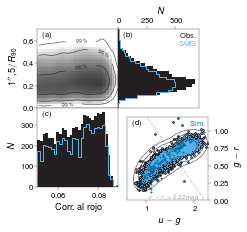

In [7]:
fig = figure(figsize=(2.5, 2.5))

gs1 = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, left=0, top=1)
ax00 = fig.add_subplot(gs1[0, 0], xticklabels=[])
ax01 = fig.add_subplot(gs1[0, 1])
ax10 = fig.add_subplot(gs1[1, 0])

ax01.tick_params(labelleft=False, labelbottom=False, labeltop=True, left=False, bottom=False, top=True)
ax01.xaxis.set_label_position("top")

gs2 = matplotlib.gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1, left=0, top=1, right=0.95, bottom=0.05)
ax11 = fig.add_subplot(gs2[1, 1])

ax11.tick_params(labelleft=False, labelright=True, left=False, right=True)
ax11.yaxis.set_label_position("right")

axs = array([[ax00, ax01], [ax10, ax11]])
# ---------------------------------------------------------------------------
#axs[0,0].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
#axs[0,0].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
axs[0,0].text(0.05, 0.90, r"(a)", size="x-small", ha="left", transform=axs[0,0].transAxes)
rx = axs[0,0].set_xlim(0.05, 0.09)
ry = axs[0,0].set_ylim(0.00, 0.70)
axs[0,0].set_ylabel(r"$1''.5/R_{90}$")

H, xe, ye = histogram2d(cat["redshift"][clean], rat[clean], (30,30), [last(30,rx),last(30,ry)])
H = gaussian_filter(H, sigma=1.5)
H[H==0] = 1
den = axs[0,0].pcolormesh(xe[:-1], ye[:-1], log10(H.T), cmap=greys_map, vmin=0.0, vmax=2.0, edgecolor="face")

sample_data = densitycontour.ScatterData(cat["redshift"][clean], rat[clean])
raster = sample_data.rasterize(nbins_x=30, nbins_y=30, clipping=[last(30,rx),last(30,ry)])
raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
cont = contours.plot((0.99,0.95,0.68), axes=axs[0,0], linewidths=0.5, colors=samples["dark"])
contours.cilabel(cont, fontsize=5, fmt=r"%.0f", inline=True)
# ---------------------------------------------------------------------------
#axs[0,1].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
#axs[0,1].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
axs[0,1].text(0.05, 0.90, r"(b)", size="x-small", ha="left", transform=axs[0,1].transAxes)
axs[0,1].text(0.95, 0.90, r"Obs.", color=samples["dark"], size="x-small", ha="right", transform=axs[0,1].transAxes)
axs[0,1].text(0.95, 0.80, r"SMG", color=samples["cold"], size="x-small", ha="right", transform=axs[0,1].transAxes)
rg = axs[0,1].set_ylim(0.0, 0.70)
axs[0,1].set_xlabel(r"$N$")
axs[0,1].hist(rat[clean], 30, histtype="stepfilled", lw=0, color=samples["dark"], range=rg, orientation="horizontal")
axs[0,1].hist(rat[mask_m16], 30, histtype="step", lw=1, color=samples["cold"], range=rg, orientation="horizontal")
# ---------------------------------------------------------------------------
#axs[1,0].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
#axs[1,0].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
axs[1,0].text(0.05, 0.90, r"(c)", size="x-small", ha="left", transform=axs[1,0].transAxes)
rg = axs[1,0].set_xlim(0.05, 0.09)
axs[1,0].set_xlabel(r'Corr. al rojo')
axs[1,0].set_ylabel(r"$N$")
axs[1,0].hist(cat["redshift"][clean], 30, histtype="stepfilled", lw=0, color=samples["dark"], range=rg)
axs[1,0].hist(cat["redshift"][mask_m16], 30, histtype="step", lw=1, color=samples["cold"], range=rg)
# ---------------------------------------------------------------------------
#axs[1,1].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
#axs[1,1].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
xl, yl = axs[1,1].set_xlim(0.6, 2.3), axs[1,1].set_ylim(0.0, 1.2)
axs[1,1].text(0.05, 0.90, r"(d)", size="x-small", ha="left", transform=axs[1,1].transAxes)
axs[1,1].text(0.95, 0.90, r"Sim.", color=seds["jpas"], size="x-small", ha="right", transform=axs[1,1].transAxes)
axs[1,1].set_xlabel(r"$u-g$")
axs[1,1].set_ylabel(r"$g-r$")

H, xe, ye = histogram2d((cat["u_mag"]-cat["g_mag"])[clean], (cat["g_mag"]-cat["r_mag"])[clean], (30,30), [last(30,xl),last(30,yl)])
H = gaussian_filter(H, sigma=1.5)
H[H==0] = 1
#den = axs[1,1].pcolormesh(xe[:-1], ye[:-1], log10(H.T), cmap=greys_map, vmin=0.0, vmax=3.0, edgecolor="face")
axs[1,1].scatter((cat["u_mag"]-cat["g_mag"])[clean], (cat["g_mag"]-cat["r_mag"])[clean], lw=0, c=samples["dark"], s=7)

axs[1,1].scatter((cat["u_mag"]-cat["g_mag"])[mask_m16], (cat["g_mag"]-cat["r_mag"])[mask_m16], lw=0, c=samples["cold"], s=1)

axs[1,1].scatter(u_lib-g_lib, g_lib-r_lib, lw=0, c=seds["jpas"], s=4)
axs[1,1].plot(xl, 2.22-array(xl), "-.", color=samples["medium"], lw=0.5)
axs[1,1].text(0.87, 0.03, r"$u-r=2.22\,$mag", ha="right", size="xx-small", color=samples["medium"], transform=axs[1,1].transAxes)

sample_data = densitycontour.ScatterData((cat["u_mag"]-cat["g_mag"])[clean], (cat["g_mag"]-cat["r_mag"])[clean])
raster = sample_data.rasterize(nbins_x=30, nbins_y=30, clipping=[last(30,xl),last(30,yl)])
raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
cont = contours.plot((0.99,0.95,0.68), axes=axs[1,1], linewidths=0.5, colors=samples["dark"])
# ---------------------------------------------------------------------------

fig.savefig("{}sample_chars".format(od))

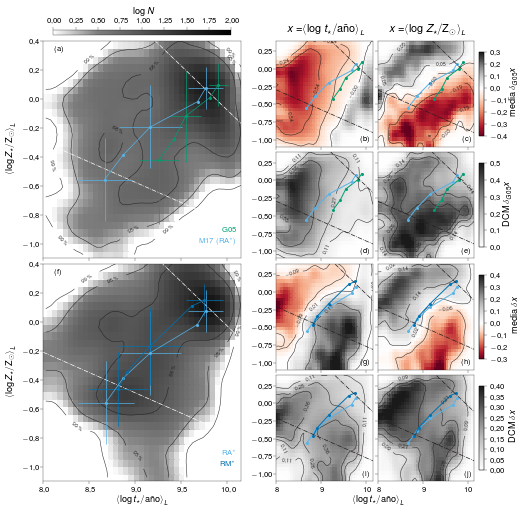

In [21]:
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
table = spec_ne, jpas_ne
mask = mask_m16, clean
N, bins = zip(histogram(col[mask[0]], 3, (1.3,3.0)), histogram(col[mask[1]], 3, (1.3,3.0)))
slopes = [-0.28, -0.45, -0.61]
sl_col = [seds["spec"], samples["dark"], samples["warm"]], [seds["jpas"], samples["dark"], seds["spec"]]
#sl_col = ["#56B4E9", samples["dark"], "#D55E00"], ["#009E73", samples["dark"], "#56B4E9"]
x, y = "log_t_L_mod", "log_Z_L_mod"
xr, yr = "log_t_L", "log_Z_L"
red_lb = xr, yr
red_st = mean, rms_flat
red_nm = "media", "DCM"
ab = ("a", ["b c".split(), "d e".split()]), ("f", ["g h".split(), "i j".split()])
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(7,7))

ax0 = subplot2grid((41, 44), (1, 0), rowspan=20, colspan=20, xticklabels=[], ylabel=params[yr], xlim=rx, ylim=ry)
ac0 = subplot2grid((41, 44), (0, 1), colspan=18)

ax11 = subplot2grid((41, 44), (1, 23), rowspan=10, colspan=10, title=r"$x=${}".format(params[xr]), xticklabels=[], xlim=rx, ylim=ry)
ax12 = subplot2grid((41, 44), (1, 33), rowspan=10, colspan=10, title=r"$x=${}".format(params[yr]), xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)
ax21 = subplot2grid((41, 44), (11, 23), rowspan=10, colspan=10, xticklabels=[], xlim=rx, ylim=ry)
ax22 = subplot2grid((41, 44), (11, 33), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)
ac1 = subplot2grid((41, 44), (2, 43), rowspan=8)
ac2 = subplot2grid((41, 44), (12, 43), rowspan=8)

AX = [(ax0, array([[ax11, ax12], [ax21, ax22]]))]
AC = [array([ac1, ac2])]

ax1 = subplot2grid((41, 44), (21, 0), rowspan=20, colspan=20, xlabel=params[xr], ylabel=params[yr], xlim=rx, ylim=ry)

ax11 = subplot2grid((41, 44), (21, 23), rowspan=10, colspan=10, xticklabels=[], xlim=rx, ylim=ry)
ax12 = subplot2grid((41, 44), (21, 33), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)
ax21 = subplot2grid((41, 44), (31, 23), rowspan=10, colspan=10, xlim=rx, ylim=ry)
ax22 = subplot2grid((41, 44), (31, 33), rowspan=10, colspan=10, yticklabels=[], xlim=rx, ylim=ry)
ac1 = subplot2grid((41, 44), (22, 43), rowspan=8)
ac2 = subplot2grid((41, 44), (32, 43), rowspan=8)

AX += [(ax1, array([[ax11, ax12], [ax21, ax22]]))]
AC += [array([ac1, ac2])]

fig.tight_layout()
fig.subplots_adjust(hspace=0.9, wspace=0.9)
#--------------------------------------------------------------------------------------------------------------------------
for k in xrange(2):
    ax0, axs = AX[k]
    acs = AC[k]

    H_al, xe, ye = histogram2d(table[k][x][mask[k]], table[k][y][mask[k]], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    H_al = gaussian_filter(H_al, sigma=1.5)
    H_al[H_al==0] = 1
    den = ax0.pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=greys_map, norm=MidpointNormalize(midpoint=0.5), vmin=0.0, vmax=2.0, edgecolor="face")
    
    if k==0:
        cb0 = colorbar(den, cax=ac0, orientation="horizontal")
        cb0.set_label(r"\log{N}")
        ac0.tick_params(direction="out", bottom=False, top=True, labelbottom=False, labeltop=True)
        ac0.xaxis.set_label_position("top")
    else:
        axs[1,1].set_xlabel(params[xr], x=0.0)

    sample_data = densitycontour.ScatterData(table[k][x][mask[k]], table[k][y][mask[k]])
    raster = sample_data.rasterize(nbins_x=nbins[0], nbins_y=nbins[1], clipping=[last(nbins[0],rx),last(nbins[1],ry)])
    raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
    contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
    cont = contours.plot((0.99,0.95,0.68), axes=ax0, linewidths=0.5, colors=samples["dark"])
    contours.cilabel(cont, fontsize=5, fmt=r"%.0f", inline=True)

    for ibin in xrange(bins[k].size-1):
        if ibin==1: continue
        if ibin<bins[k].size-2:
            bin_mask = (col[mask[k]]>=bins[k][ibin])&(col[mask[k]]<bins[k][ibin+1])
        else:
            bin_mask = (col[mask[k]]>=bins[k][ibin])&(col[mask[k]]<=bins[k][ibin+1])
        p0 = median(table[k][x][mask[k]][bin_mask]), median(table[k][y][mask[k]][bin_mask])
        ax0.plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.7, color="w")

    if k==0:
        cg05, tg05, tg05_rms = binner(col[mask_m16], g05[x][mask_g05], 5, (1.3,3.0))
        cg05, Zg05, Zg05_rms = binner(col[mask_m16], g05[y][mask_g05], 5, (1.3,3.0))
        ax0.errorbar(tg05, Zg05, Zg05_rms, tg05_rms, "-o", sl_col[k][2], mew=0, ms=3, lw=0.7, color=sl_col[k][2], errorevery=2, zorder=99)
        
        ax0.text(0.97, 0.07, r"M17 ({})".format(speco_lb), color=sl_col[k][0], size="x-small", ha="right", transform=ax0.transAxes)
        ax0.text(0.97, 0.12, r"G05", color=sl_col[k][2], size="x-small", ha="right", transform=ax0.transAxes)
    else:
        cspec, tspec, tspec_rms = binner(col[clean], spec_ne[x][clean], 5, (1.3,3.0))
        cspec, Zspec, Zspec_rms = binner(col[clean], spec_ne[y][clean], 5, (1.3,3.0))
        ax0.errorbar(tspec, Zspec, Zspec_rms, tspec_rms, "-o", sl_col[k][2], mew=0, ms=3, lw=0.7, color=sl_col[k][2], errorevery=2, zorder=99)
        
        ax0.text(0.97, 0.07, jpaso_lb, color=sl_col[k][0], size="x-small", ha="right", transform=ax0.transAxes)
        ax0.text(0.97, 0.12, speco_lb, color=sl_col[k][2], size="x-small", ha="right", transform=ax0.transAxes)
    
    ax0.text(0.05, 0.95, r"(%s)"%ab[k][0], size="x-small", ha="left", transform=ax0.transAxes)

    cm16, tm16, tm16_rms = binner(col[mask[k]], table[k][x][mask[k]], 5, (1.3,3.0))
    cm16, Zm16, Zm16_rms = binner(col[mask[k]], table[k][y][mask[k]], 5, (1.3,3.0))
    ax0.errorbar(tm16, Zm16, Zm16_rms, tm16_rms, "-o", sl_col[k][0], mew=0, ms=3, lw=0.7, color=sl_col[k][0], errorevery=2, zorder=99)
    #--------------------------------------------------------------------------------------------------------------------------
    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        H_al, xe, ye = histogram2d(table[k][x][mask[k]], table[k][y][mask[k]], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
        if k==0:
            Z = redux_histogram2d(xe, ye, table[k][x][mask[k]], table[k][y][mask[k]], g05_con[red_lb[j]], stat=red_st[i], fill=0.0)
        else:
            Z = redux_histogram2d(xe, ye, table[k][x][mask[k]], table[k][y][mask[k]], obs_con[red_lb[j]][mask[k]], stat=red_st[i], fill=0.0)

        Z = gaussian_filter(Z, sigma=1.5)

        lv = map(round, percentile(Z, [25.0,50.0,75.0]), [2]*3)
        rz_i, rz_f = map(round, percentile(Z, [0.0,100.0]), [1]*2)

        red = axs[i,j].pcolormesh(xe[:-1], ye[:-1], Z.T, cmap=diver_map, vmin=rz_i, vmax=rz_f, norm=MidpointNormalize(midpoint=0.0), edgecolor="face")

        cb = colorbar(red, cax=acs[i])

        cont = axs[i,j].contour(xe[:-1], ye[:-1], Z.T, lv, colors=samples["dark"], linewidths=0.5, linestyles="-")
        clabel(cont, fontsize=5, fmt=r"$%.2f$", inline=True)

        if k==0:
            axs[i,j].plot(tg05, Zg05, "-o", mew=0, ms=3, color=sl_col[k][2])
            cb.set_label(r"%s $\delta_{G05} x$"%(red_nm[i]))
        else:
            axs[i,j].plot(tspec, Zspec, "-o", mew=0, ms=3, color=sl_col[k][2])
            cb.set_label(r"%s $\delta x$"%(red_nm[i]))

        axs[i,j].plot(tm16, Zm16, "-o", mew=0, ms=3, color=sl_col[k][0])

        axs[i,j].text(0.95, 0.05, r"(%s)"%ab[k][1][i][j], size="x-small", ha="right", transform=axs[i,j].transAxes)

        for ibin in xrange(bins[k].size-1):
            if ibin==1: continue
            if ibin<bins[k].size-2:
                bin_mask = (col[mask[k]]>=bins[k][ibin])&(col[mask[k]]<bins[k][ibin+1])
            else:
                bin_mask = (col[mask[k]]>=bins[k][ibin])&(col[mask[k]]<=bins[k][ibin+1])
            p0 = median(table[k][x][mask[k]][bin_mask]), median(table[k][y][mask[k]][bin_mask])
            axs[i,j].plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.7, color=samples["dark"])

fig.savefig("{}{}".format(od, "AMR_con_maps"))

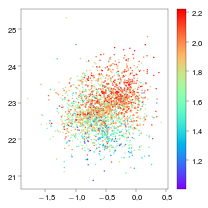

In [9]:
indexes = "D4000 Hbeta Hdg Mg2Fe MgFep".split()
prop = "log_t_L log_Z_L".split()

# fig, axs = subplots(2, 5, figsize=(7,3.3), sharex=True, sharey=True)

# axs[0,0].set_xlim(-1.0,+1.0)
# axs[0,0].set_ylim(-0.7,+0.7)

# for i,j in it.product(range(axs.shape[0]), range(axs.shape[1])):
#    axs[i,j].plot(infilling[indexes[j]], col[mask_m16], ".", color=samples["light"])

mask = col[mask_m16]<2.22
sc = scatter(g05_con["log_t_L"][mask], infilling["Hbeta"][mask], lw=0, c=col[mask_m16][mask], s=2, cmap=cm.rainbow)
colorbar(sc)

#No hay una correlación clara entre la diferencia de los indices medidos en el espectro observado y el ajustado.
#Paraciera que los indices calculados de los espectros observados no es confiable.
#Hay anchos equivalentes de Hbeta mayores que 20\AA aún cuando no hay línea en emisión o absorción.
#Por esta razón las galaxias rojas muestran un mayor ancho equivalente en este rasgo.

In [10]:
def delta_trends(deltas, delta_ran, delta_ids, delta_labels, properties, prop_ran, prop_ids, prop_labels, class_prop, nbins=5, delta_mask=None, hide_bottom_labels=False):
    fig, axs = subplots(len(delta_ids), len(prop_ids), figsize=(7.0,2.5), sharex="col", sharey=True)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    ins = inset_axes(axs[0,0], width="90%", height="2.5%", loc=9)

    ylim(delta_ran)
    if delta_mask is None:
        _mask = ones(deltas[delta_ids[0]].size, dtype=np.bool)
    else:
        _mask = delta_mask
    for i, j in it.product(range(axs.shape[0]), range(axs.shape[1])):
        x, y = prop_ids[j], delta_ids[i]

        snr, delt, edelt = binner(properties[x], deltas[y][_mask], nbins, range=prop_ran[j])
        snr, clas, eclas = binner(properties[x], class_prop, nbins, range=prop_ran[j])

        axs[i,j].plot(properties[x], deltas[y][_mask], ",", color=samples["light"], alpha=0.5)
        axs[i,j].plot(snr, gaussian_filter(delt,1.5), "-", color=samples["dark"], lw=1.0)
        axs[i,j].plot(snr, gaussian_filter(delt-edelt[0],1.5), "-", color=samples["dark"], lw=0.5)
        axs[i,j].plot(snr, gaussian_filter(delt+edelt[1],1.5), "-", color=samples["dark"], lw=0.5)
        cs = axs[i,j].scatter(snr, gaussian_filter(delt,1.5), c=clas, lw=1.0, edgecolors=samples["dark"], cmap=seque_map, vmin=1.3, vmax=3.0, zorder=9, s=14)
        axs[i,j].scatter(snr, gaussian_filter(delt-edelt[0],1.5), c=clas-eclas[0], lw=0.5, edgecolors=samples["dark"], cmap=seque_map, vmin=1.3, vmax=3.0, zorder=9, s=7)
        axs[i,j].scatter(snr, gaussian_filter(delt+edelt[1],1.5), c=clas+eclas[1], lw=0.5, edgecolors=samples["dark"], cmap=seque_map, vmin=1.3, vmax=3.0, zorder=9, s=7)
        
        axs[i,j].axhline(ls=":", color=samples["dark"], lw=0.5)
        axs[i,j].set_xlim(prop_ran[j])

        if axs[i,j].is_last_row():
            axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
            if not hide_bottom_labels:
                axs[i,j].set_xlabel(prop_labels[j])
            else:
                axs[i,j].tick_params(labelbottom=False)
        if axs[i,j].is_first_col():
            axs[i,j].set_ylabel(delta_labels[y])
            axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
    
    cb = colorbar(cs, cax=ins, orientation="horizontal")
    cb.set_label(r"$u-r$")
    
    ins.tick_params(top=False, bottom=True, direction="out", labeltop="off", labelbottom="on", labelsize="x-small")
    ins.xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
    
    return fig

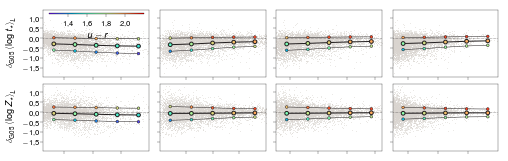

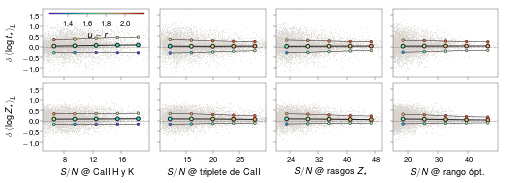

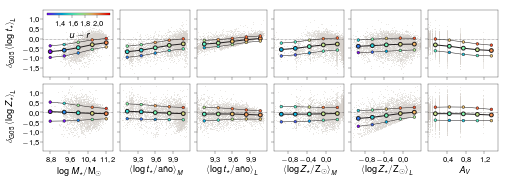

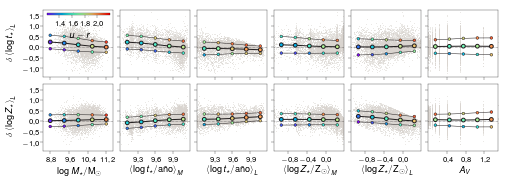

In [11]:
fig = delta_trends(g05_con, (-0.9,+0.9), ("log_t_L","log_Z_L"), delta_g05, snr_spec[mask_m16], ((5.0,20.0),(10.0,30.0),(20.0,50.0),(15.0,50.0)), ("snr_CaHK","snr_CaII","snr_Zfea","snr_wall"), (r"$S/N$ @ CaII H y K",r"$S/N$ @ triplete de CaII",r"$S/N$ @ rasgos $Z_\star$",r"$S/N$ @ rango \'opt."), col[mask_m16], hide_bottom_labels=True)
fig.savefig("{}{}".format(od, "dis_g05_vs_snr"))
fig = delta_trends(obs_con, (-0.9,+0.9), ("log_t_L","log_Z_L"), delta, snr_spec[clean], ((5.0,20.0),(10.0,30.0),(20.0,50.0),(15.0,50.0)), ("snr_CaHK","snr_CaII","snr_Zfea","snr_wall"), (r"$S/N$ @ CaII H y K",r"$S/N$ @ triplete de CaII",r"$S/N$ @ rasgos $Z_\star$",r"$S/N$ @ rango \'opt."), col[clean], delta_mask=clean)
fig.savefig("{}{}".format(od, "dis_obs_vs_snr"))
fig = delta_trends(g05_con, (-0.9,+0.9), ("log_t_L","log_Z_L"), delta_g05, spec_ne[mask_m16], ((8.5,11.5),(9.0,10.2),(9.0,10.2),(-1.1,0.4),(-1.1,0.4),(0.0,1.5)), ("M_mod", "log_t_M_mod", "log_t_L_mod", "log_Z_M_mod","log_Z_L_mod","Av_mod"), [params[kw] for kw in ("M","log_t_M","log_t_L","log_Z_M","log_Z_L","Av")], col[mask_m16])
fig.savefig("{}{}".format(od, "dis_g05_vs_par"))
fig = delta_trends(obs_con, (-0.9,+0.9), ("log_t_L","log_Z_L"), delta, spec_ne[clean], ((8.5,11.5),(9.0,10.2),(9.0,10.2),(-1.1,0.4),(-1.1,0.4),(0.0,1.5)), ("M_mod", "log_t_M_mod", "log_t_L_mod", "log_Z_M_mod","log_Z_L_mod","Av_mod"), [params[kw] for kw in ("M","log_t_M","log_t_L","log_Z_M","log_Z_L","Av")], col[clean], delta_mask=clean)

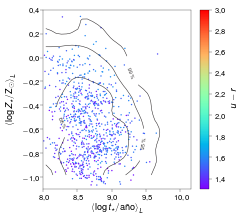

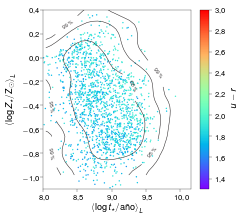

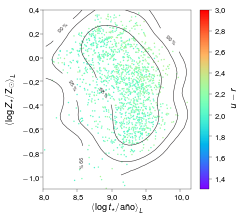

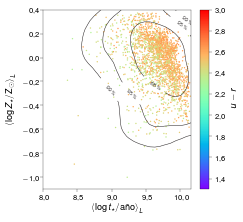

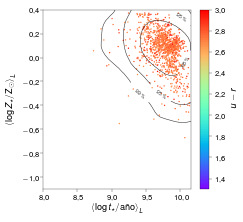

In [12]:
xlm, ylm = (8.0, 10.15), (-1.1, 0.4)

n, ce = histogram(col[clean], 5, range=(1.3,3.0))
for i in xrange(ce.size-1):
    mask = (ce[i]<=col[clean])&(col[clean]<ce[i+1])
    
    figure()
    scatter(spec_ne[clean]["log_t_L_mod"][mask], spec_ne[clean]["log_Z_L_mod"][mask], c=col[clean][mask], s=2, lw=0, cmap=seque_map, vmin=1.3, vmax=3.0)
    
    sample_data = densitycontour.ScatterData(spec_ne[clean]["log_t_L_mod"][mask], spec_ne[clean]["log_Z_L_mod"][mask])
    raster = sample_data.rasterize(nbins_x=30, nbins_y=40, clipping=[last(30,(8.0,10.2)),last(40,(-1.0,+0.4))])
    raster.pdf = gaussian_filter(raster.pdf, sigma=2)
    contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
    cont = contours.plot((0.99,0.95,0.68), axes=gca(), linewidths=0.5, colors=samples["dark"])
    contours.cilabel(cont, fontsize=5, fmt=r"%.0f", inline=True)
    
    xlim(xlm)
    ylim(ylm)
    xlabel(params["log_t_L"])
    ylabel(params["log_Z_L"])
    colorbar().set_label(r"$u-r$")

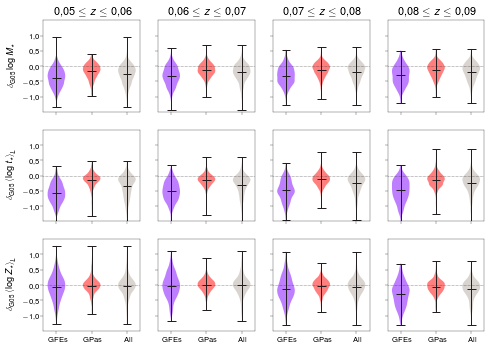

In [13]:
N_rs, ran_rs = 4, (0.05,0.09)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_L", "log_Z_L"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs[mask_m16], pags[mask_m16], algs[mask_m16]
lbs = sfgs_lb, pags_lb, r"All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,5), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both', integer=True)
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (cat[mask_m16]["redshift"]>=ran_rs[0]+j*step_rs)&(cat[mask_m16]["redshift"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"$%.2f\leq z\leq%.2f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta_g05[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([g05_con[kws[i]][rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
#fig.savefig("{}con_g05_vs_col_vs_redshift".format("img/"))

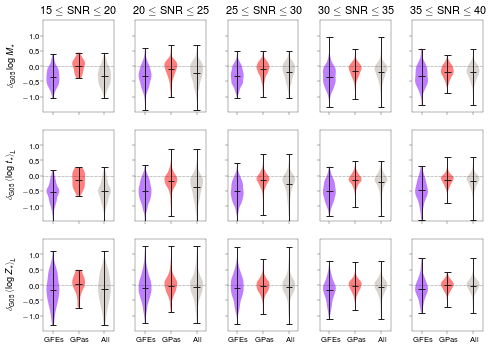

In [14]:
N_rs, ran_rs = 5, (15, 40)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_L", "log_Z_L"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs[mask_m16], pags[mask_m16], algs[mask_m16]
lbs = sfgs_lb, pags_lb, r"All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,5), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both', integer=True)
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec[mask_m16]["snr_Zfea"]>=ran_rs[0]+j*step_rs)&(snr_spec[mask_m16]["snr_Zfea"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"$%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta_g05[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([g05_con[kws[i]][rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
#fig.savefig("{}con_g05_vs_col_vs_snr_wall".format("img/"))

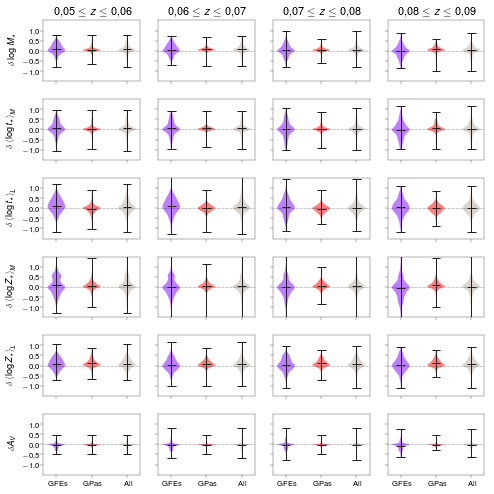

In [15]:
N_rs, ran_rs = 4, (0.05,0.09)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = sfgs_lb, pags_lb, r"All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both', integer=True)
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (cat["redshift"]>=ran_rs[0]+j*step_rs)&(cat["redshift"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"$%.2f\leq z\leq%.2f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
#fig.savefig("{}con_vs_col_vs_redshift".format("img/"))

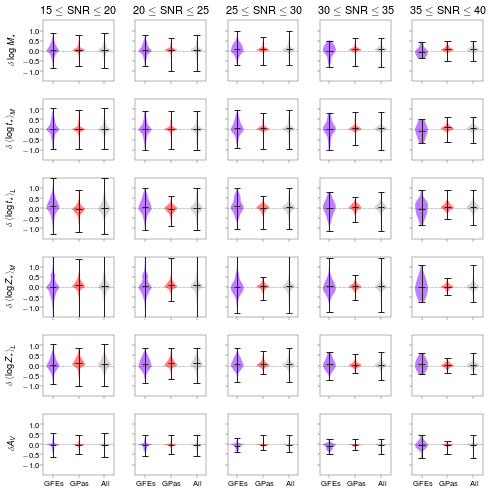

In [16]:
N_rs, ran_rs = 5, (15, 40)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = sfgs_lb, pags_lb, r"All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both', integer=True)
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_wall"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_wall"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"$%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
#fig.savefig("{}con_vs_col_vs_snr_wall".format("img/"))

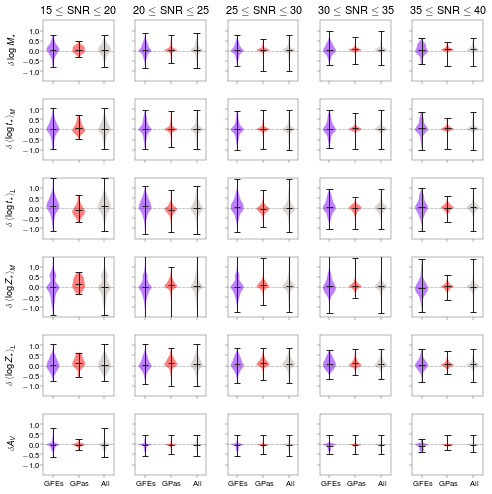

In [17]:
N_rs, ran_rs = 5, (15, 40)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = sfgs_lb, pags_lb, r"All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both', integer=True)
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_Zfea"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_Zfea"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"$%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
#fig.savefig("{}con_vs_col_vs_snr_zfea".format("img/"))

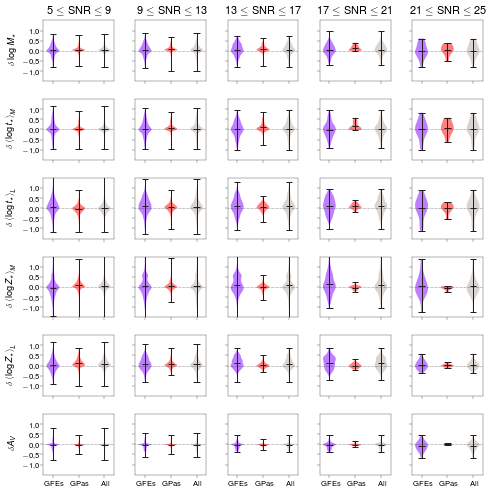

In [18]:
N_rs, ran_rs = 5, (5, 25)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = sfgs_lb, pags_lb, r"All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both', integer=True)
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_CaHK"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_CaHK"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"$%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
#fig.savefig("{}con_vs_col_vs_snr_cahk".format("img/"))

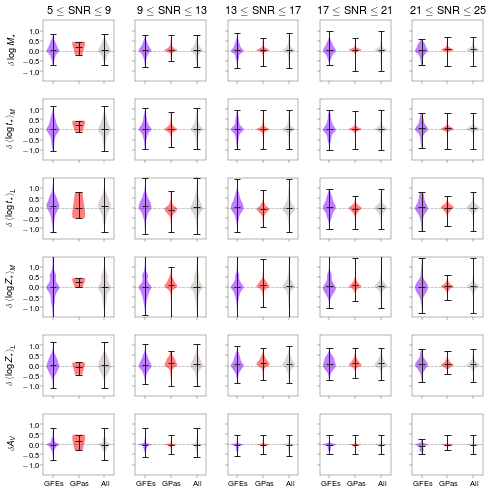

In [19]:
N_rs, ran_rs = 5, (5, 25)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = sfgs_lb, pags_lb, r"All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both', integer=True)
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_CaII"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_CaII"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"$%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
#fig.savefig("{}con_vs_col_vs_snr_caii".format("img/"))

In [20]:
if False:
    out_dir = os.path.expandvars("$phd/inputs/real_deal/outs/")
    mask = (obs_con["log_Z_M"][clean]>0.55)&(obs_con["log_Z_M"][clean]<0.6)&sfgs[clean]
    kw = ["M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"]
    for i, n in enumerate(cat["input_file"][clean][mask][50:70]):
        jpas_out = "dynbasfit_processed_nem_JPAS_{}.log".format(n.strip(".fit"))
        spec_out = "dynbasfit_processed_SPEC_{}.log".format(n.strip(".fit"))

        wlj, flj, fjm = loadtxt("{}{}{}".format(out_dir, "nem_jpas/", jpas_out), usecols=(0,1,5), unpack=True)
        wls, fls, fsm = loadtxt("{}{}{}".format(out_dir, "spec/", spec_out), usecols=(0,1,5), unpack=True)

        figure()
        title(r"$\delta x=%.2f,%.2f,%.2f,%.2f,%.2f,%.2f$"%tuple(obs_con[k][clean][mask][50:70][i] for k in kw))
        semilogy(wls[fls>0], fls[fls>0], "-", color=samples["light"])
        semilogy(wls, fsm, "-", color=samples["dark"])
        semilogy(wlj, flj, ".", color=samples["warm"], ms=10)
        semilogy(wlj, fjm, "*", color=samples["hot"], ms=7)
        axvline(3933.663, ls="--", lw=0.5, color=samples["dark"])
        axvline(3968.468, ls="--", lw=0.5, color=samples["dark"])

        xlim(3500, 4200)
        xlabel(r"$\lambda$ [\AA]")
        ylabel(r"Flux [L$\odot$/\AA]")
    
# parece haber una correlación entre la intensidad relativa de las líneas H y K de CaII con la diferencia
# entre los flujos J-PAS y Spec. en esa región espectral. Probablemente esa correlación se traduce en
# una correlación entre la intensidad de las mismas líneas y las discrepancias.